In [11]:
import numpy as np
import os,sys
sys.path.append(os.path.realpath('/Users/jaredgridley/Projects/CryptoResearch2023/Papers/FGW/lib'))
from graph import graph_colors,draw_rel,draw_transp,Graph,wl_labeling
from ot_distances import Fused_Gromov_Wasserstein_distance,Wasserstein_distance
import copy
from data_loader import load_local_data,histog,build_noisy_circular_graph
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pickle
import ot

In [2]:
sushi_liquidity = pd.read_csv("sushi_liquidity_positions.csv")

sushi_liquidity_snaps = pd.read_csv("sushi_liquidity_position_snapshots.csv")

sushi_pool_creators = pd.read_csv("sushi_pool_creators.csv")

In [3]:
# Create User Features
sushi_user_creations = sushi_pool_creators["contractCreator"].value_counts()
sushi_users = sushi_liquidity["user.id"].drop_duplicates()
sushi_tokens = list(set(sushi_liquidity["pair.token0.id"]).union(
    set(sushi_liquidity["pair.token1.id"])))

# First time uncomment this
# users_to_feats = dict()
# tokens_to_feats = dict()

file = open('sushi_feature_dicts.pkl', 'rb')
d = pickle.load(file)
users_to_feats = d[0] 
tokens_to_feats = d[1]
file.close()


In [4]:
len(users_to_feats)

49597

In [ ]:
# Create User Features 2

for add in sushi_users:
    if add not in users_to_feats.keys():
        feats = {"uniq_neighbors": -1, "liq_snaps": -
                 1, "pools_created": 0, "avg_snaps_pool": -1}

        user_snaps = sushi_liquidity_snaps[sushi_liquidity_snaps["user.id"] == add]
        user_snap_feats = user_snaps.nunique()

        feats["uniq_neighbors"] = user_snap_feats["pair.id"]
        feats["liq_snaps"] = user_snap_feats["id"]
        feats["avg_snaps_pool"] = np.mean(
            user_snaps["pair.id"].value_counts().values)

        if add in sushi_user_creations:
            feats["pools_created"] = sushi_user_creations[add]

        users_to_feats[add] = feats
    

In [12]:
# Token Features 2

for add in sushi_tokens:
    if add not in tokens_to_feats.keys():
        feats = {"uniq_neighbors": 0, "liq_snaps": -1,
                "pools_created": -1, "avg_snaps_pool": -1}

        token_snaps = sushi_liquidity_snaps[(sushi_liquidity_snaps["pair.token0.id"]
                                            == add) | (sushi_liquidity_snaps["pair.token1.id"] == add)]
        token_snap_stats = token_snaps.nunique()

        feats["uniq_neighbors"] = token_snap_stats["user.id"]

        tokens_to_feats[add] = feats



In [58]:
file = open('sushi_feature_dicts.pkl', 'wb')
pickle.dump([users_to_feats, tokens_to_feats], file)
file.close()


In [5]:
users_vec_feats = {}
tokens_vec_feats = {}

for u in users_to_feats.keys():
    users_vec_feats[u] = np.array(list(users_to_feats[u].values()))
for t in tokens_to_feats.keys():
    tokens_vec_feats[t] = np.array(list(tokens_to_feats[t].values()))


In [51]:
avail_liq = sushi_liquidity[sushi_liquidity["user.id"].isin(users_to_feats.keys())]
avail_liq = avail_liq[(avail_liq["pair.token0.id"].isin(tokens_to_feats.keys())) &
                      (avail_liq["pair.token1.id"].isin(tokens_to_feats.keys()))]
users = avail_liq["user.id"].drop_duplicates()

# Graph 1 sample
users1 = users.sample(7, random_state=9)
user1_w_feats = {key: users_to_feats[key] for key in users1}        # for dirac
user1_vec_feats = {key: users_vec_feats[key] for key in users1}     # or euclidean
graph1_df = avail_liq[avail_liq["user.id"].isin(users1)]
tokens1 = set(graph1_df["pair.token0.id"]).union(
               set(graph1_df["pair.token1.id"]))
tokens1_w_feats = {key: tokens_to_feats[key] for key in tokens1}    # dirac
tokens1_vec_feats = {key: tokens_vec_feats[key] for key in tokens1} # euclidean

# Graph 2 sample
users2 = users.sample(6, random_state=5)
user2_w_feats = {key: users_to_feats[key] for key in users2}        # dirac
user2_vec_feats = {key: users_vec_feats[key] for key in users2}     # euclidean
graph2_df = avail_liq[avail_liq["user.id"].isin(users2)]
tokens2 = list(set(graph2_df["pair.token0.id"]).union(
               set(graph2_df["pair.token1.id"])).intersection(
               set(tokens_to_feats.keys())))
tokens2_w_feats = {key: tokens_to_feats[key] for key in tokens2}    # dirac
tokens2_vec_feats = {key: tokens_vec_feats[key] for key in tokens2} # euclidean


In [52]:
def create_graphs(users_w_feats, tokens_w_feats, df):
    # works only for setups like in cell above
    G = nx.Graph()
    G.add_nodes_from(users_w_feats)
    G.add_nodes_from(tokens_w_feats)

    el = set((row["user.id"], row["pair.token0.id"]) for i, row in df.iterrows()).union(
        set((row["user.id"], row["pair.token1.id"])for i, row in df.iterrows()))

    G.add_edges_from(el)
    G.remove_nodes_from(list(nx.isolates(G)))
    


    colors = []
    for node in G:
        if node in tokens_w_feats.keys():
            colors.append("blue")
        else:
            colors.append("orange")
    
    G = nx.convert_node_labels_to_integers(G, ordering="default")
    # Now for the paper graph
    g = Graph()
    g.add_attibutes(users_w_feats)
    g.add_attibutes(tokens_w_feats)
    for e in el:
        g.add_edge(e)

    return G, g, colors




In [53]:
G1_d, g1_d, colors1 = create_graphs(user1_w_feats, tokens1_w_feats, graph1_df)
G2_d, g2_d, colors2 = create_graphs(user2_w_feats, tokens2_w_feats, graph2_df)

G1_e, g1_e, colors1 = create_graphs(user1_vec_feats, tokens1_vec_feats, graph1_df)
G2_e, g2_e, colors2 = create_graphs(user2_vec_feats, tokens2_vec_feats, graph2_df)

Graph with 16 nodes and 17 edges
Graph with 12 nodes and 14 edges


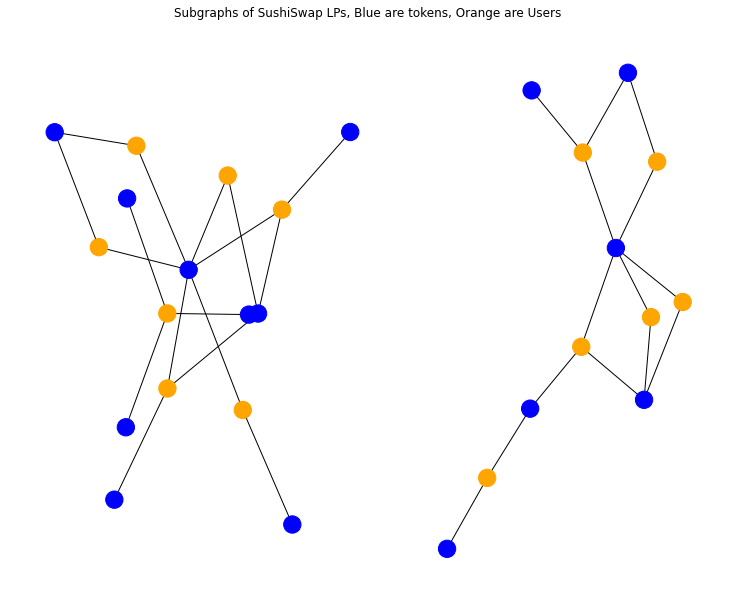

In [54]:
plt.figure(figsize=(10, 8))
vmin = 0
vmax = 7

draw_rel(G1_d, draw=False, vmin=vmin, vmax=vmax,
         with_labels=False, colors=colors1)
print(G1_d)
draw_rel(G2_d, draw=False, vmin=vmin, vmax=vmax,
         with_labels=False, shiftx=2.5, swipy=True, colors=colors2)
print(G2_d)
plt.title('Subgraphs of SushiSwap LPs, Blue are tokens, Orange are Users')

plt.show()


In [55]:
M, C1, C2, t1masses, t2masses = Fused_Gromov_Wasserstein_distance(alpha=0.5, features_metric='sqeuclidean', method='shortest_path').get_key_info(g1_e, g2_e)


In [56]:
alpha = 0.5
pi, log = ot.gromov.fused_gromov_wasserstein(
    M, C1, C2, t1masses, t2masses, alpha=alpha, log=True)
log["fgw_dist"]

70761759.79296874

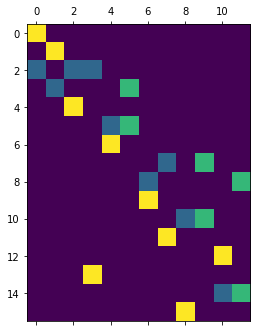

In [57]:
plt.matshow(pi)

In [51]:
alpha = 0.5
dfgw = Fused_Gromov_Wasserstein_distance(
    alpha=alpha, features_metric='dirac', method='shortest_path').graph_d(g1_d, g2_d)
dw = Wasserstein_distance(features_metric='dirac').graph_d(g1_d, g2_d)
dgw = Fused_Gromov_Wasserstein_distance(
    alpha=1, features_metric='dirac', method='shortest_path').graph_d(g1_d, g2_d)
print('Wasserstein distance={}, Gromov distance={} \nFused Gromov-Wasserstein distance for alpha {} = {}'.format(dw, dgw, alpha, dfgw))


Wasserstein distance=0.3909965320944839, Gromov distance=0.10230675978316636 
Fused Gromov-Wasserstein distance for alpha 0.5 = 0.2631343955748804


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/linesearch.py:730: RuntimeWarning: divide by zero encountered in double_scalars
  alpha2 = (-b + np.sqrt(abs(b**2 - 3 * a * derphi0))) / (3.0*a)
/Users/jaredgridley/Projects/CryptoResearch2023/Papers/FGW/lib/optim.py:76: RuntimeWarning: invalid value encountered in multiply
  return f(xk + alpha1 * pk, *args)
/Users/jaredgridley/Projects/CryptoResearch2023/Papers/FGW/lib/optim.py:212: RuntimeWarning: invalid value encountered in multiply
  return np.sum(M * G) + reg * f(G)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Error with alpha=0.05


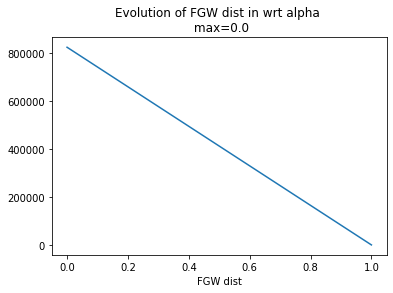

In [55]:
# We plot the evolution of the FGW distance with respect to the alpha parameter
alld = []
x = np.arange(0, 1.01, 0.05)
xn = []
for alpha in x:
    try:
        d = Fused_Gromov_Wasserstein_distance(
            alpha=alpha, features_metric='sqeuclidean', method='shortest_path').graph_d(g1_e, g2_e)
        alld.append(d)
        xn.append(alpha)
    except:
        print("Error with alpha=" + str(alpha))
plt.plot(xn, alld)
plt.title('Evolution of FGW dist in wrt alpha \n max={}'.format(
    x[np.argmax(alld)]))
plt.xlabel('Alpha')
plt.xlabel('FGW dist')
plt.show()


This is interesting, this graph indicates the the features are the least important for being able to seperate the graph. i.e. there is no trade-off between analyzing the structure and features. In the first graph implementation, it found that structure was the most important. 

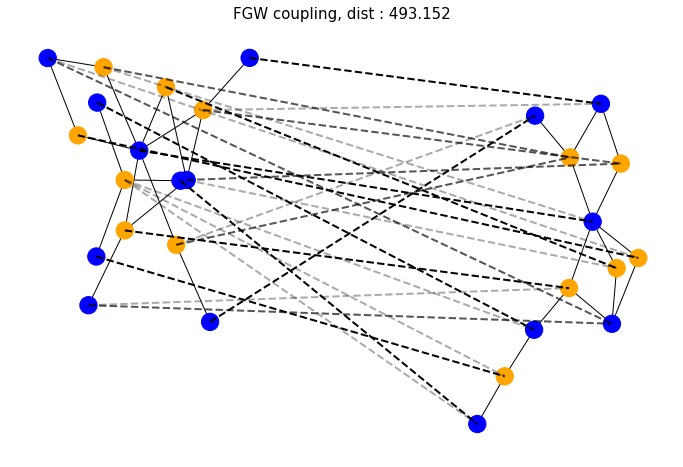

In [61]:
fig = plt.figure(figsize=(12, 8))
thresh = 0.004
gwdist = Fused_Gromov_Wasserstein_distance(
    alpha=1, features_metric='sqeuclidean')
d = gwdist.graph_d(g1_e, g2_e)
plt.title('FGW coupling, dist : '+str(np.round(d, 3)), fontsize=15)
draw_transp(g1_e, g2_e, gwdist.transp, shiftx=4, shifty=0.5, thresh=thresh,
            swipy=True, swipx=False, with_labels=False, vmin=vmin, vmax=vmax, colors=[colors1, colors2])
plt.show()
